In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv
/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset_info.txt
/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
train_idx = train['id']
train.drop(columns='id', inplace=True)
train_org = pd.read_csv('/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')
sam_sub = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')

In [3]:
train_comp = pd.concat([train, train_org], axis=0)

In [4]:
train.head(3)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.8,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.9,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531


In [5]:
train_comp_enh = train_comp.drop_duplicates()
train_comp_enh.dropna(subset='Listening_Time_minutes', inplace=True)
target = train_comp_enh['Listening_Time_minutes']

<ipython-input-5-0798abe9369f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_comp_enh.dropna(subset='Listening_Time_minutes', inplace=True)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Listening_Time_minutes', ylabel='Count'>

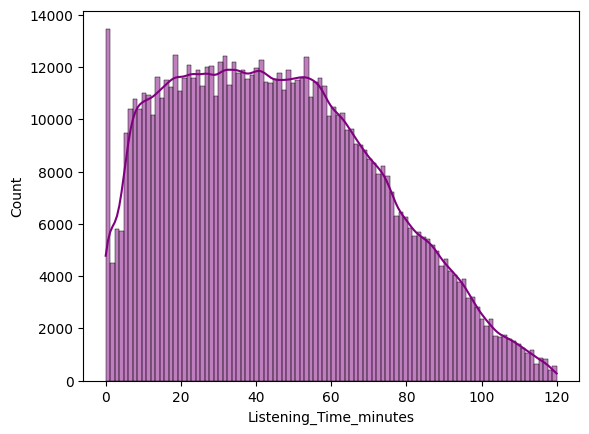

In [6]:
import seaborn as sns
sns.histplot(target, kde=True, color='purple', bins=100)

In [7]:
# train['Podcast_Name'].value_counts()

In [8]:
from sklearn.model_selection import KFold
from catboost import Pool
from xgboost import DMatrix
# from sklearn.metrics import root_mean_squared_error


def root_mean_squared_error(y_true, y_preds):
    return np.sqrt(((y_true-y_preds)**2).mean())
def cv_score(X, y, model_dict, Iam=None, oof=False, folds=10, seed=1):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    if not oof:
        for i, (name, model) in enumerate(model_dict.items()):
            categorical_cols_cat = X.columns
            categorical_cols = X.select_dtypes(include=['object', 'category']).columns
            reg_model = clone(model)
            scores = []
            preds = []
            for train_idx, valid_idx in kf.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
                y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
                if name == 'cat':
                    X_train[categorical_cols_xgb] = X_train[categorical_cols_xgb].fillna('missing')
                    X_valid[categorical_cols_xgb] = X_valid[categorical_cols_xgb].fillna('missing')
                    X_train[categorical_cols_xgb] = X_train[categorical_cols_xgb].astype('str').astype('category')
                    X_valid[categorical_cols_xgb] = X_valid[categorical_cols_xgb].astype('str').astype('category')
                    train_pool = Pool(data=X_train, label=y_train, cat_features=X_train[categorical_cols_xgb].columns.values)
                    valid_pool = Pool(data=X_valid, cat_features=X_valid[categorical_cols_xgb].columns.values)
                    reg_model.fit(train_pool)
                    preds = reg_model.predict(valid_pool)
                    score = root_mean_squared_error(y_valid, preds)
                    scores.append(score)

                elif name== 'xgb':
                    X_train[categorical_cols] = X_train[categorical_cols].astype('str').astype('category')
                    X_valid[categorical_cols] = X_valid[categorical_cols].astype('str').astype('category')
                    reg_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
                    # X_train[categorical_cols_xgb] = X_train[categorical_cols_xgb].astype('str').astype('category')
                    # X_valid[categorical_cols_xgb] = X_valid[categorical_cols_xgb].astype('str').astype('category')
                    
                    # train_dmatrix = DMatrix(data=X_train, label=y_train)
                    # valid_dmatrix = DMatrix(data=X_valid, label=y_valid)
                    
                    # params = {
                    #     'objective': 'reg:squarederror',
                    #     'eval_metric': 'rmse',
                    # }
                    # params = model.get('params', {})
                    # xgb_model = xgb.train(params, train_dmatrix, num_boost_rounds=reg_model.get('num_boost_round', 100), evals=[(val_dmatrix), 'validation'])
                    preds = reg_model.predict(X_valid)
                    if Iam is not None:
                        preds_inv = inv_boxcox(preds, Iam)
                        # preds_inv = pd.Series(preds_inv)
                        scores = root_mean_squared_error(y_valid, preds)
                        scores.append(score)
                    else:
                        score = root_mean_squared_error(y_valid, preds)
                        scores.append(score)

                elif name== 'etr':
                    X_train[categorical_cols] = X_train[categorical_cols].astype('str').astype('category')
                    X_valid[categorical_cols] = X_valid[categorical_cols].astype('str').astype('category')
                    o_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

                    X_train[categorical_cols] = o_encoder.fit_transform(X_train[categorical_cols])
                    X_valid[categorical_cols] = o_encoder.transform(X_valid[categorical_cols])
                    X_train = X_train.fillna(0)
                    X_valid = X_valid.fillna(0)
                    reg_model.fit(X_train, y_train)
                    preds = reg_model.predict(X_valid)
                    # preds = np.expm1(preds)
                    score = root_mean_squared_error(y_valid, preds)
                    scores.append(score)

                else:
                    X_train[categorical_cols] = X_train[categorical_cols].astype('str').astype('category')
                    X_valid[categorical_cols] = X_valid[categorical_cols].astype('str').astype('category')
                    reg_model.fit(X_train, y_train)
                    if Iam is not None:
                        preds = reg_model.predict(X_valid)
                        preds_inv = inv_boxcox(preds, Iam)
                        score = root_mean_squared_error(y_valid, preds_inv)
                        scores.append(score)
                    else:
                        preds = reg_model.predict(X_valid)
                        score = root_mean_squared_error(y_valid, preds)
                        scores.append(score)

            print(f'Scores for model {name} across {folds} folds :', np.mean(scores))
            

In [9]:
seed=1

In [10]:
def outliers_remover(df, features, threshold=1.5):
    df_clean = df.copy()
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)

        IQR = Q3 - Q1
        lower = Q1 - threshold*IQR
        upper = Q3 + threshold*IQR

        mask = (df[feature]>=lower) & (df[feature]<=upper)
        df_clean = df_clean.loc[mask]

    return df_clean

# train_clean = outliers_remover(train, ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Host_Popularity_percentage', 'Number_of_Ads'])
# train_clean.shape

In [11]:
from itertools import combinations

def create_cat_features(df, combo_sizes=[2,3,4]):
    df = df.copy(deep=False) 
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    str_df = df[cat_cols].astype(str)
    
    all_combos = []
    for r in combo_sizes:
        all_combos.extend(combinations(cat_cols, r))
    
    for cols in all_combos:
        col_name = '_'.join(cols)
        df[col_name] = str_df[list(cols)].agg('_'.join, axis=1)
        
    return df

def te_ce_cat_features(df, test):
    df = df.copy()
    test = test.copy()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    # str_df = df[cat_cols].astype(str)

    for col in cat_cols:
        # mappings for categorical columns for both train and test sets
        if df[col].nunique()>15:
            te_map = df.groupby(col)['Listening_Time_minutes'].mean()
            ce_map = df.groupby(col)['Listening_Time_minutes'].sum()

            df[f'{col}_te'] = df[col].map(te_map)
            df[f'{col}_ce'] = df[col].map(ce_map)

            test[f'{col}_te'] = test[col].map(te_map)
            test[f'{col}_ce'] = test[col].map(ce_map)

            # for unseen categories in test set 
            global_mean = df['Listening_Time_minutes'].mean()
            # global_count = df['Listening_Time_minutes'].sum()
            df[f'{col}_te'] = df[f'{col}_te'].fillna(global_mean)
            test[f'{col}_te'] = test[f'{col}_te'].fillna(global_mean)
            test[f'{col}_ce'] = test[f'{col}_ce'].fillna(0)
        else:
            continue
        

    return df, test


train_comp_enh = create_cat_features(train_comp_enh)
test = create_cat_features(test)

train_comp_enh, test = te_ce_cat_features(train_comp_enh, test)

<ipython-input-11-4c6a2cfdde95>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[f'{col}_ce'] = test[col].map(ce_map)
<ipython-input-11-4c6a2cfdde95>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_te'] = df[col].map(te_map)
<ipython-input-11-4c6a2cfdde95>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `ne

In [12]:
train_comp_enh.head(3)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,...,Episode_Title_Genre_Publication_Day_Publication_Time_te,Episode_Title_Genre_Publication_Day_Publication_Time_ce,Episode_Title_Genre_Publication_Day_Episode_Sentiment_te,Episode_Title_Genre_Publication_Day_Episode_Sentiment_ce,Episode_Title_Genre_Publication_Time_Episode_Sentiment_te,Episode_Title_Genre_Publication_Time_Episode_Sentiment_ce,Episode_Title_Publication_Day_Publication_Time_Episode_Sentiment_te,Episode_Title_Publication_Day_Publication_Time_Episode_Sentiment_ce,Genre_Publication_Day_Publication_Time_Episode_Sentiment_te,Genre_Publication_Day_Publication_Time_Episode_Sentiment_ce
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,...,32.994135,791.859230,39.582903,1227.070002,42.059320,2649.737137,38.358910,2915.277170,48.884186,52257.194795
1,Joke Junction,Episode 26,119.8,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,...,49.619073,1488.572203,46.428479,1857.139145,50.608281,4200.487324,46.827953,4682.795306,43.224754,43181.529250
2,Study Sessions,Episode 16,73.9,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,...,33.650126,403.801517,38.418741,614.699850,35.485353,1206.502006,41.100653,3082.548949,43.636872,27098.497744


In [13]:
print('train shape :', train_comp_enh.shape)
print('test shape :', test.shape)

train shape : (794868, 163)
test shape : (250000, 163)


In [14]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.base import clone
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import xgboost as xgb
import lightgbm as lgb
# import catboost as cb
model_dict = {
    'xgb': xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        tree_method='hist',
        enable_categorical=True,
        random_state=seed,
        n_estimators=10000,
    ),
#     'cat': cb.CatBoostRegressor(
#         iterations=1000,
#         eval_metric='RMSE',
#         random_state=seed,
#         verbose=500,
#         devices='0',
#         task_type='GPU'
#     ),
    # 'lgbm': lgb.LGBMRegressor(random_state=seed,
    #                          # device='gpu',
    #                          # verbose=0
    #                          ),
     # 'etr': ExtraTreesRegressor(n_jobs=-1, random_state=seed),
}

X = train_comp_enh.drop(columns=['Listening_Time_minutes'])
y = target.copy()
# median_episode_length = np.median(train['Episode_Length_minutes'])
# mean_episode_length = np.mean(train['Episode_Length_minutes'])
# mean_guest_popularity = np.mean(train['Guest_Popularity_percentage'])
# median_guest_popularity = np.mean(train['Guest_Popularity_percentage'])
# X['Episode_Length_minutes'] = X['Episode_Length_minutes'].fillna(0)
# X['Guest_Popularity_percentage'] = X['Guest_Popularity_percentage'].fillna(0)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
cat_dtypes = X.select_dtypes(include=['object', 'category']).columns
X[cat_dtypes] = X[cat_dtypes].astype('str').astype('category')
# X[cat_dtypes] = encoder.fit_transform(X[cat_dtypes])
# y_transformed, Iam = boxcox(y+1)
# print(Iam)
# cv_score(X, y, model_dict)

In [15]:
train_comp_enh.to_csv('train_data_pss5e4.csv')
test.to_csv('test_data_pss5e4.csv')

In [16]:
# from sklearn.feature_selection import VarianceThreshold

# selector = VarianceThreshold(threshold=15)
# X_filtered = selector.fit_transform(X_new)

# remaining_features = X_new.columns[selector.get_support()]
# len(remaining_features)

In [17]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import OrdinalEncoder

X_new = X.copy()
# X_new = X_new.fillna(0)
# lgb_reg = lgb.LGBMRegressor(random_state=seed)
lgb_reg = xgb.XGBRegressor(random_state=seed, verbose=0, enable_categorical=True)
# lgb_reg = HistGradientBoostingRegressor(random_state=seed)
# lgb_reg = ExtraTreesRegressor(n_jobs=-1, random_state=seed)

lgb_reg.fit(X_new, y)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:08:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [18]:
# import xgboost as xgb
# importance_scores = lgb_reg.get_booster().get_score(importance_type='weight')
# sorted_features = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

# top_25_features = [feature[0] for feature in sorted_features[:25]]

# print("Top 25 Features:")
# print(top_25_features)

In [19]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(10, 10))  
# xgb.plot_importance(
#     lgb_reg,
#     ax=ax,
#     max_num_features=25,  # Display only the top 25 features
#     importance_type="weight",  # Options: 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
# )
# plt.title("XGB Top 25 Feature Importances")
# plt.show()

In [20]:
# importances = lgb_reg.feature_importances_
# feature_names = X_new.columns  

# sorted_idx = np.argsort(importances)[::-1]  

# print("Feature ranking:")
# for i, idx in enumerate(sorted_idx):
#     print(f"{i+1}. {feature_names[idx]} ({importances[idx]:.4f})")

In [21]:
test[cat_dtypes] = test[cat_dtypes].astype('str').astype('category')
# test[cat_dtypes] = encoder.transform(test[cat_dtypes])
# test_new = test.fillna(0).copy()
preds = lgb_reg.predict(test.drop(columns='id'))

In [22]:
# preds_inv = inv_boxcox(preds, Iam)
sam_sub['Listening_Time_minutes'] = preds
sam_sub.to_csv('submission.csv', index=False)

In [23]:
preds

array([54.464314, 19.26314 , 40.064365, ...,  6.000341, 81.743095,
       62.222168], dtype=float32)